In [254]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from dotmap import DotMap

%config InlineBackend.figure_format = 'retina'

# https://www.kaggle.com/datasets/ruchi798/star-wars

In [255]:
episodes = []
factions = []
for i in range(1, 8):
    with open(f'data/interactions/starwars-episode-{i}-interactions-allCharacters.json') as f:
        episodes.append(DotMap(json.load(f)))
    try:
        with open(f'data/factions/factions_{i}.json') as f:
            factions.append(json.load(f))
    except:
        factions.append({})


In [256]:
networks = []
for i, episode in enumerate(episodes):
    G = nx.Graph()
    for node in episode.nodes:
        if len(factions[i]) > 0:
            if node.name in factions[i]['dark']:
                faction = 'dark'
            elif node.name in factions[i]['light']:
                faction = 'light'
            elif node.name in factions[i]['neutral']:
                faction = 'neutral'
            else:
                raise KeyError
        G.add_node(node.name, value=node.value, color=node.colour, faction=faction)
    for link in episode.links:
        G.add_edge((nl:=list(G.nodes))[link.source], nl[link.target], weight=link.value)
    networks.append(G)

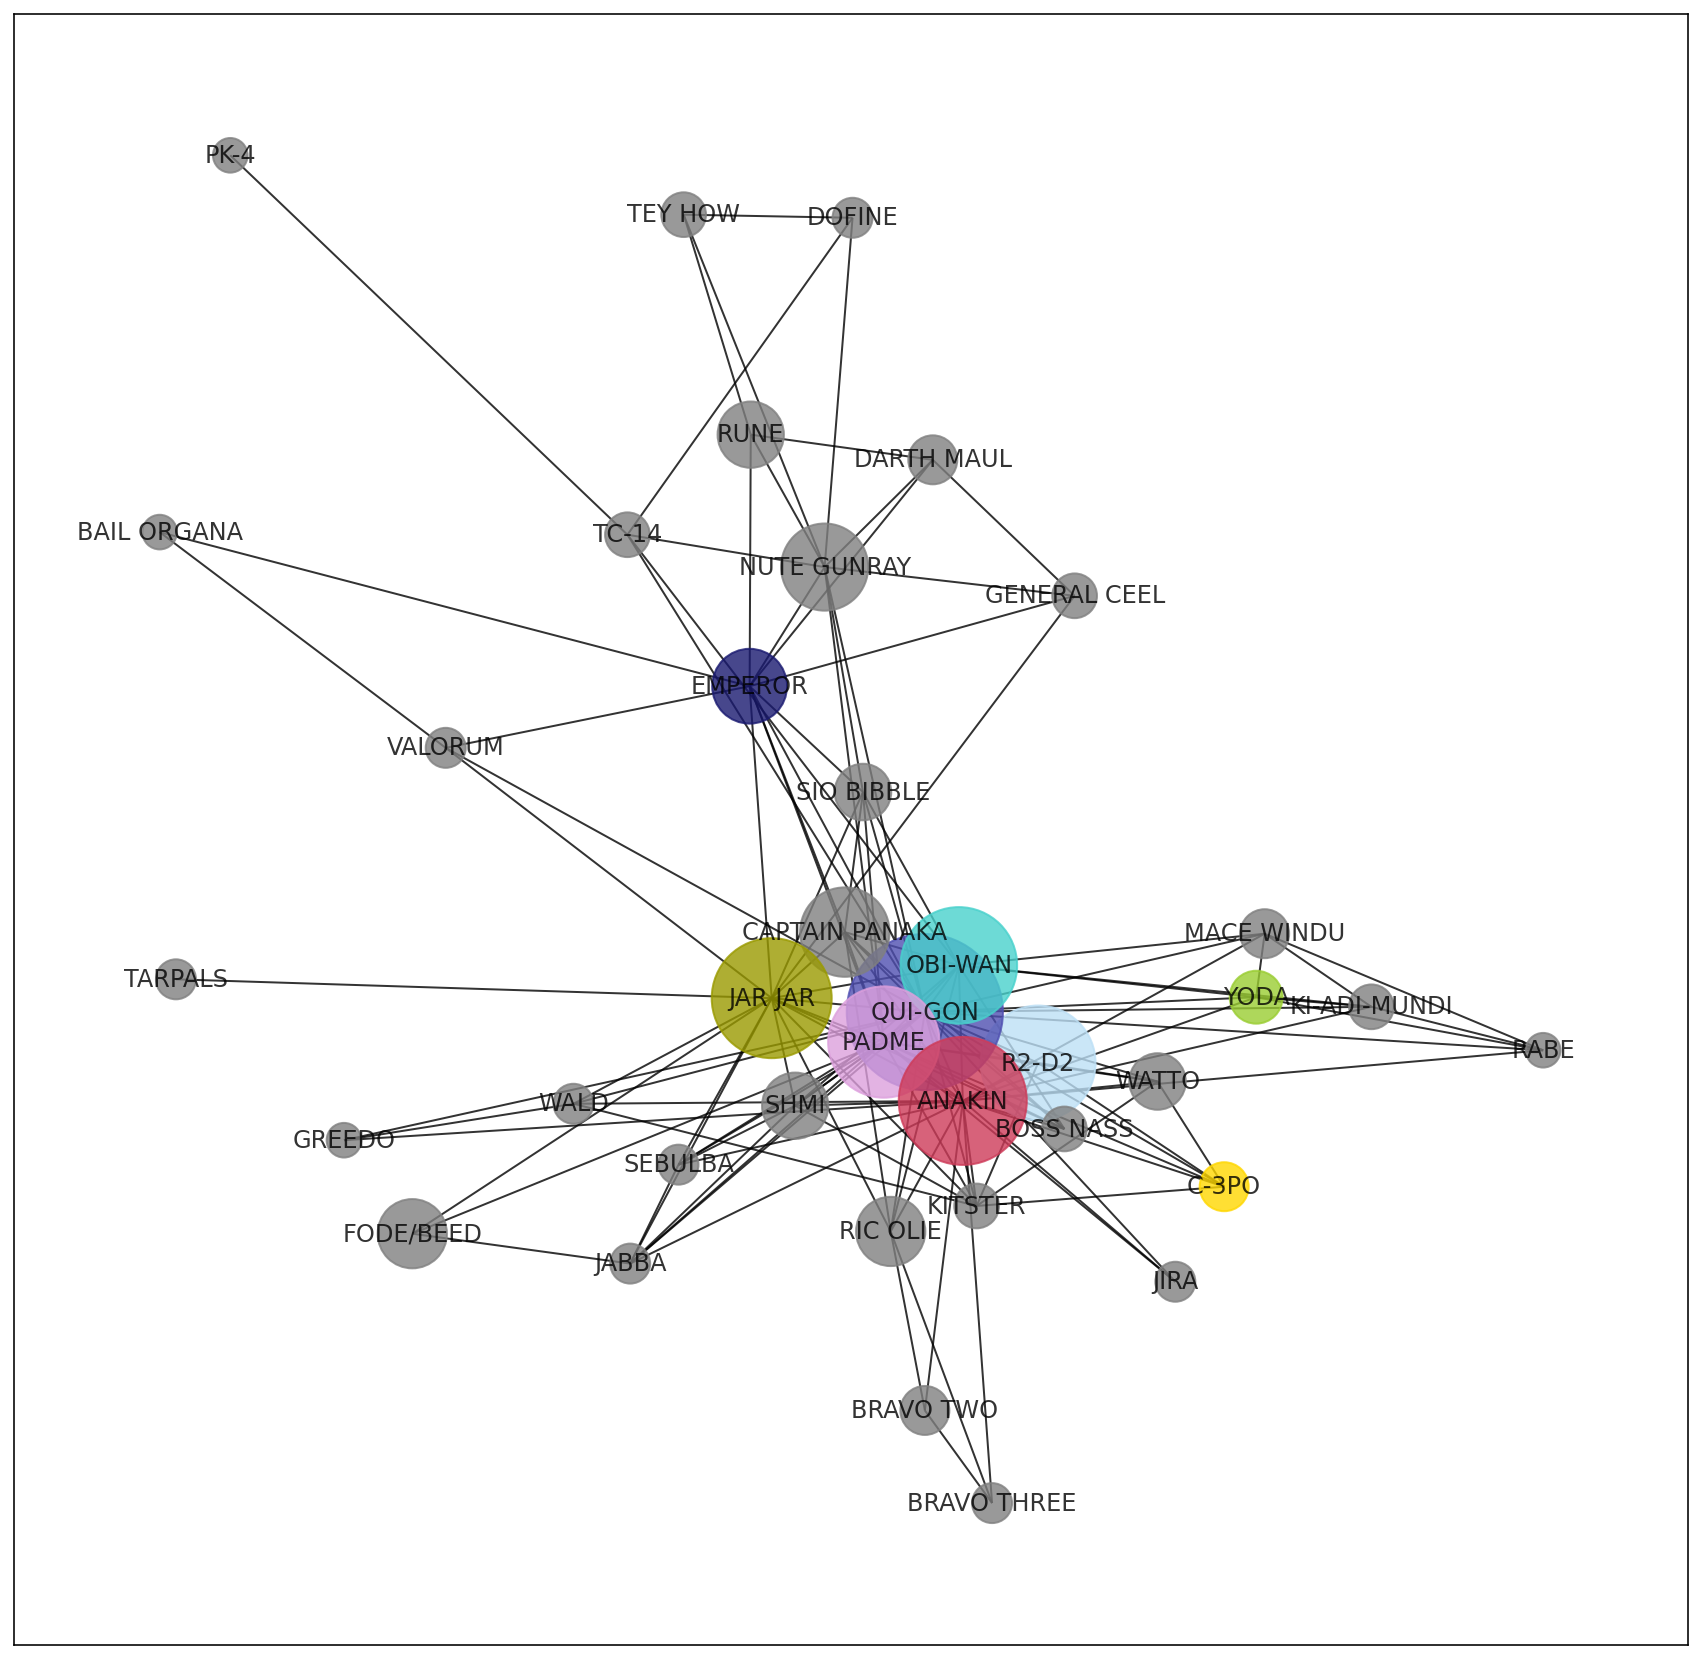

In [277]:
episode = 1

G = networks[episode-1]
pos = nx.spring_layout(G, k=10, iterations=10000)
node_sizes = [G.nodes[node]['value'] * 100 for node in G.nodes]
node_colors = [G.nodes[node]['color'] for node in G.nodes]
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos, node_size=node_sizes, node_color=node_colors, with_labels=True, alpha=0.8)
plt.show()

In [275]:
print(', '.join(G.nodes))

LUKE, R2-D2, CHEWBACCA, BB-8, LOR SAN TEKKA, POE, KYLO REN, CAPTAIN PHASMA, FINN, UNKAR PLUTT, REY, GENERAL HUX, LIEUTENANT MITAKA, HAN, BALA-TIK, SNOKE, MAZ, C-3PO, LEIA, SNAP, ADMIRAL ACKBAR, ADMIRAL STATURA, YOLO ZIFF, COLONEL DATOO, ELLO ASTY, JESS, NIV LEK


In [259]:
# Compute betweenness centrality for each node, sort by value
bet_cen = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
for node, value in bet_cen:
    print(f'{node}: {value}')

ANAKIN: 0.3833822091886608
OBI-WAN: 0.31480109272447976
PADME: 0.1789467253176931
KI-ADI-MUNDI: 0.0625
JAR JAR: 0.06213037634408606
MACE WINDU: 0.06106165340036309
YODA: 0.06106165340036309
COUNT DOOKU: 0.036982875994972755
EMPEROR: 0.028351487222454955
BAIL ORGANA: 0.009538646837033933
SENATOR ASK AAK: 0.006888440860215053
TAUN WE: 0.0020161290322580645
JANGO FETT: 0.0020161290322580645
C-3PO: 0.002016129032258064
R2-D2: 0.0
CAPTAIN TYPHO: 0.0
ORN FREE TAA: 0.0
PK-4: 0.0
SIO BIBBLE: 0.0
SOLA: 0.0
JOBAL: 0.0
RUWEE: 0.0
LAMA SU: 0.0
BOBA FETT: 0.0
WATTO: 0.0
OWEN: 0.0
BERU: 0.0
CLIEGG: 0.0
SHMI: 0.0
SUN RIT: 0.0
POGGLE: 0.0
NUTE GUNRAY: 0.0
PLO KOON: 0.0


In [260]:
# Identify the main factions using graph partitioning
from networkx.algorithms import community
communities = list(community.asyn_fluidc(G, 3))

# For each community compute assortativity coefficient, clustering coefficient, diameter, efficiency
for community in communities:
    subG = G.subgraph(community)
    # print(f'Assortativity coefficient: {nx.degree_assortativity_coefficient(subG)}')
    print(f'Clustering coefficient: {nx.average_clustering(subG)}')
    # if nx.is_connected(subG):
    #     print(f'Diameter: {nx.diameter(subG)}')
    print(f'Efficiency: {nx.global_efficiency(subG)}')
    print(', '.join(community))
    print()

Clustering coefficient: 0.6616161616161617
Efficiency: 0.6909090909090909
COUNT DOOKU, PK-4, POGGLE, LAMA SU, OBI-WAN, SUN RIT, JANGO FETT, CAPTAIN TYPHO, NUTE GUNRAY, TAUN WE, BOBA FETT

Clustering coefficient: 0.7238095238095238
Efficiency: 0.8055555555555557
SENATOR ASK AAK, EMPEROR, ORN FREE TAA, JAR JAR, YODA, BAIL ORGANA, PLO KOON, MACE WINDU, KI-ADI-MUNDI

Clustering coefficient: 0.6594405594405595
Efficiency: 0.6923076923076923
WATTO, RUWEE, SHMI, CLIEGG, JOBAL, OWEN, SIO BIBBLE, PADME, BERU, SOLA, ANAKIN, C-3PO, R2-D2



In [261]:
# For each community check if it contains more nodes from one faction than the other and give that faction the community name
results = []
for i, community in enumerate(communities):
    dark, light, neutral = 0, 0, 0
    for node in community:
        if G.nodes[node]['faction'] == 'dark':
            dark += 1
        elif G.nodes[node]['faction'] == 'light':
            light += 1
        else:
            neutral += 1
    if dark > light:
        faction = 'dark'
    elif light > dark:
        faction = 'light'
    else:
        faction = 'neutral'
    results.append(faction)
    print(f'Community {i} is {faction} with {dark} dark, {light} light nodes and {neutral} neutral nodes')

separation = len(set(results)) == len(results)

Community 0 is dark with 1 dark, 0 light nodes and 10 neutral nodes
Community 1 is neutral with 1 dark, 1 light nodes and 7 neutral nodes
Community 2 is light with 0 dark, 2 light nodes and 11 neutral nodes


/Users/mike/.pyenv/versions/3.10.2/envs/dev/lib/python3.10/site-packages/netgraph/_main.py:1430: RuntimeWarning: invalid value encountered in true_divide
  values /= np.nanmax([np.nanmax(np.abs(values)), abs(vmax), abs(vmin)]) # [-1, 1]
/Users/mike/.pyenv/versions/3.10.2/envs/dev/lib/python3.10/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in true_divide
  displacement = compatibility * delta / distance_squared[..., None]


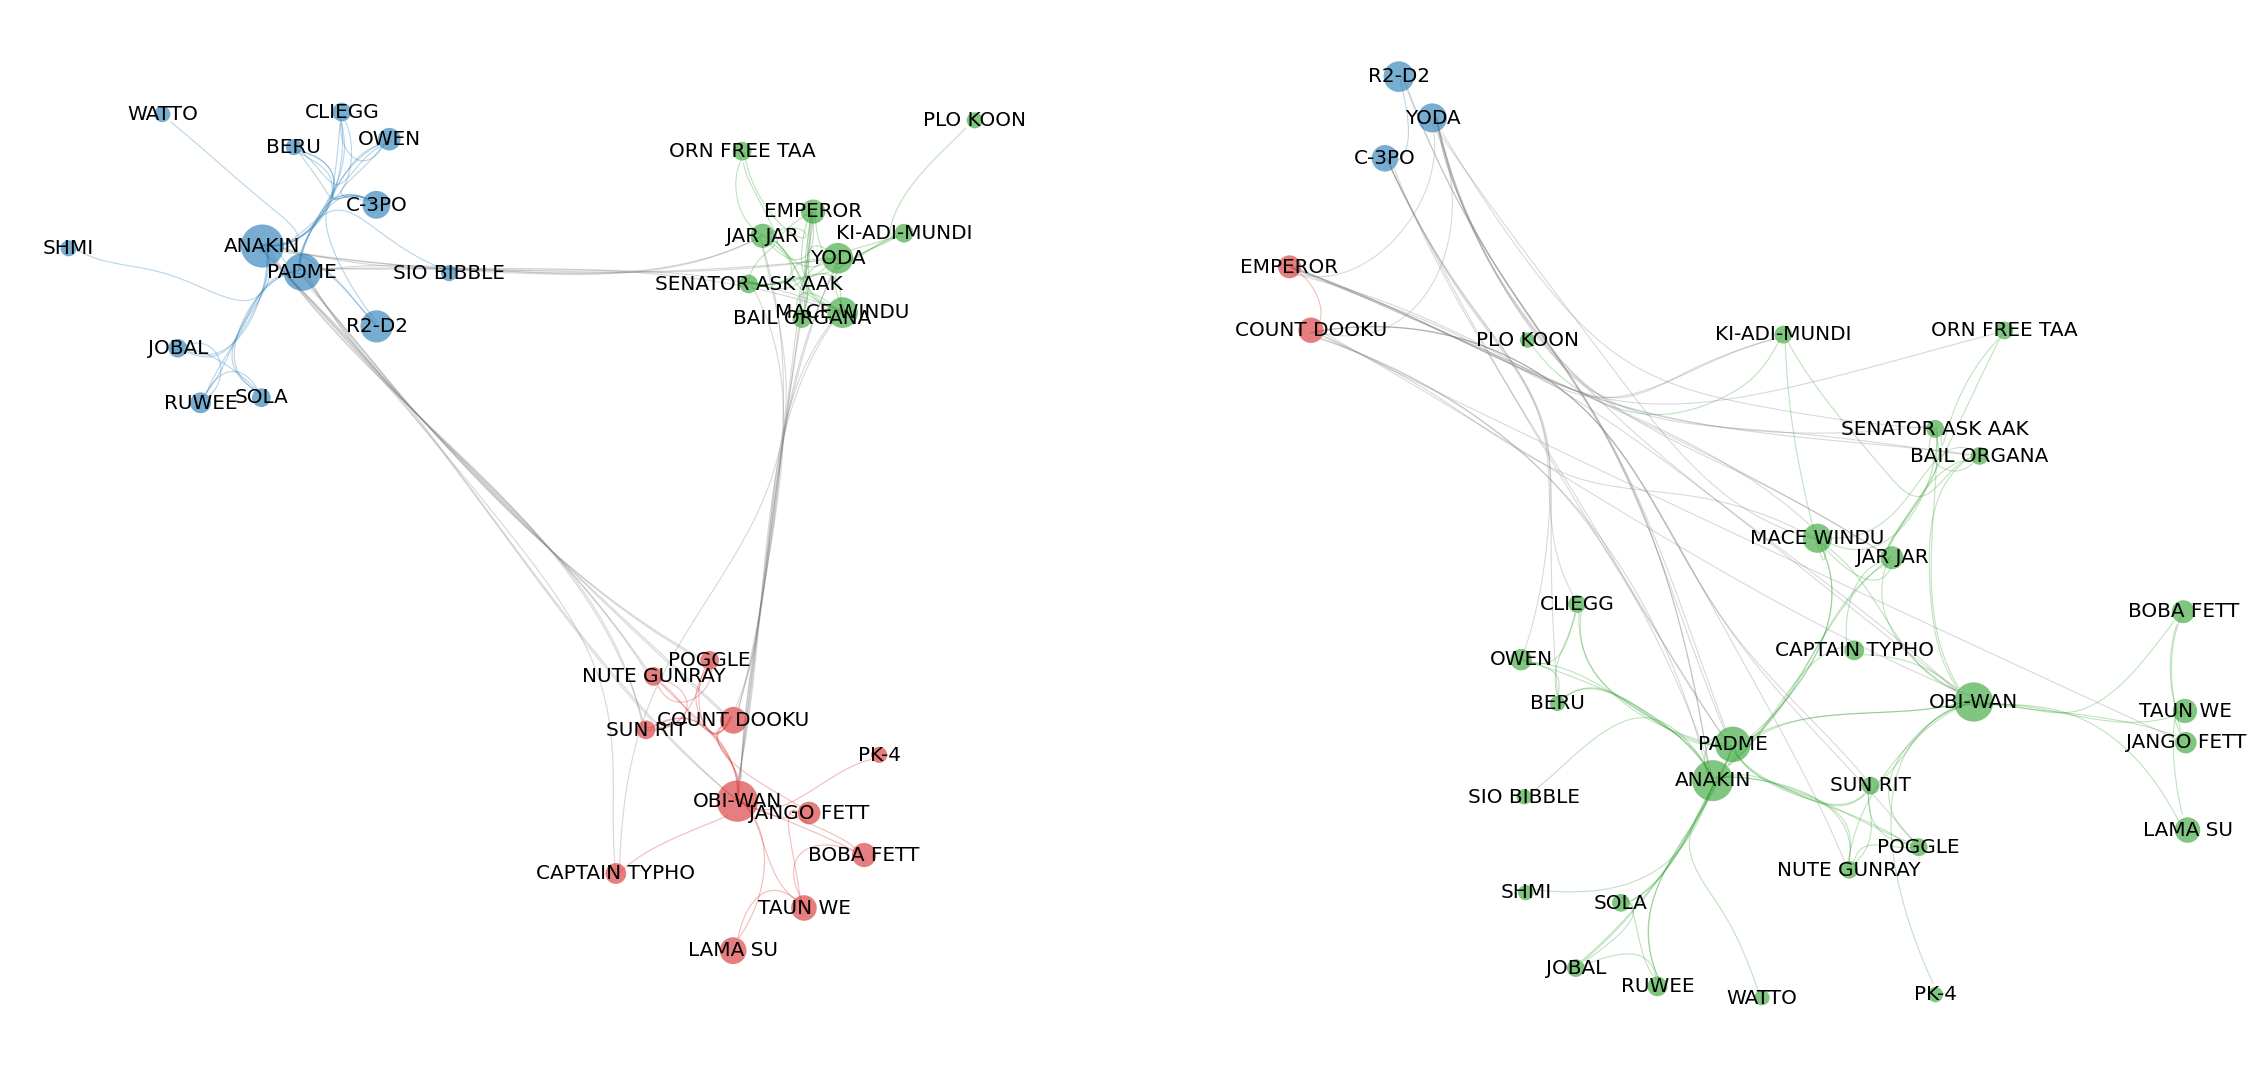

In [262]:
import netgraph

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:brown',
    6 : 'tab:pink',
}

faction_to_color = {
    'dark' : 'tab:red',
    'light' : 'tab:blue',
    'neutral' : 'tab:green',
}

if separation:
    for i, community in enumerate(communities):
        community_to_color[i] = faction_to_color[results[i]]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

_G = G.copy()
for edge in _G.edges:
    _G.edges[edge]['weight'] = 0

netgraph.Graph(_G,
    ax=ax[0],
    node_edge_width=0, 
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=(node_to_community:={node: community for community, nodes in enumerate(communities) for node in nodes})),
    node_color={node: community_to_color[community] for node, community in node_to_community.items()}, 
    node_size={node: np.log(G.nodes[node]['value'] + 1) * 1 for node in G.nodes},
    node_alpha=0.6,
    node_labels={node: node for node in G.nodes},
    node_label_fontdict=dict(size=10),
    edge_layout='bundled', 
    edge_alpha=0.3,
    edge_width=0.2,
    edge_color={edge: community_to_color[node_to_community[edge[0]]] if node_to_community[edge[0]] == node_to_community[edge[1]] else 'gray' for edge in G.edges},
)

# Draw the graph using node faction as community
netgraph.Graph(_G,
    ax=ax[1],
    node_edge_width=0,
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=(node_to_community:={node: G.nodes[node]['faction'] for node in G.nodes})),
    node_color={node: faction_to_color[faction] for node, faction in node_to_community.items()},
    node_size={node: np.log(G.nodes[node]['value'] + 1) * 1 for node in G.nodes},
    node_alpha=0.6,
    node_labels={node: node for node in G.nodes},
    node_label_fontdict=dict(size=10),
    edge_layout='bundled',
    edge_alpha=0.3,
    edge_width=0.2,
    edge_color={edge: faction_to_color[node_to_community[edge[0]]] if node_to_community[edge[0]] == node_to_community[edge[1]] else 'gray' for edge in G.edges},
)

plt.show()